GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at checkpoints/resnet18_2023-01-05_15_15_15/last.ckpt
Loaded model weights from checkpoint at checkpoints/resnet18_2023-01-05_15_15_15/last.ckpt


Validation: 0it [00:00, ?it/s]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy          0.8506401137980085
        val_loss            0.9084670543670654
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


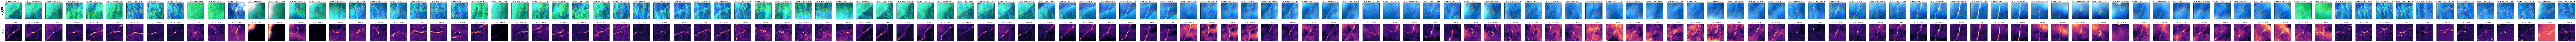

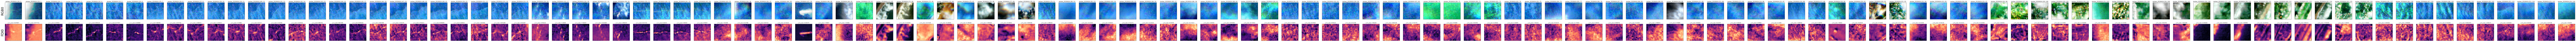

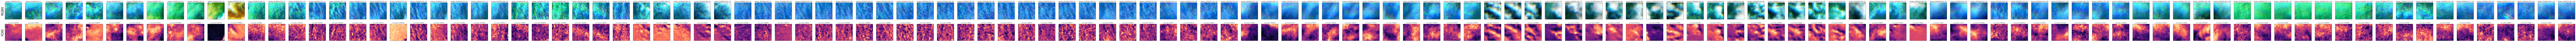

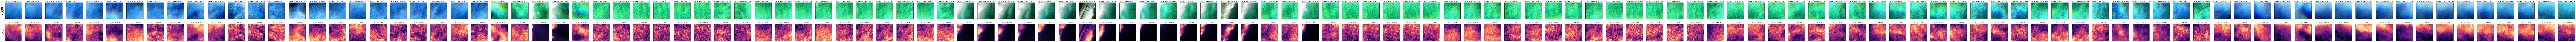

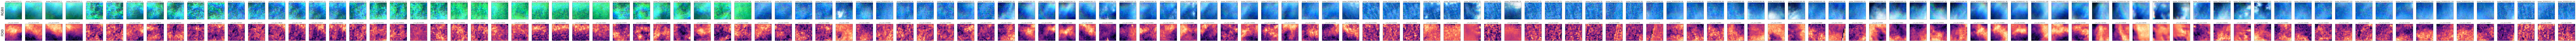

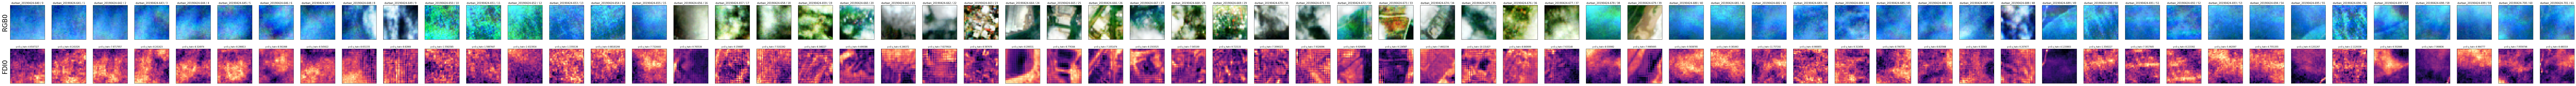

TOTAL METRICS:

y\y_hat        0        1
      0 0.765625 0.002841
      1 0.146307 0.085227


In [1]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import requests
import torch.nn.functional as F
from data.refined_floatingobjects import RefinedFlobsDataset, RefinedFlobsRegionDataset
import torch
from datetime import datetime
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from transforms import get_train_transform
from model.classifier import Classifier
from visualization import rgb, fdi, ndvi
import matplotlib.pyplot as plt
import pandas as pd

def compute_metrics(y, y_hat):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for i in range(0,len(y)):
        if (y[i] == 1 and y_hat[i] > 0):
                true_positive += 1
        elif (y[i] == 0 and y_hat[i] <= 0):
                true_negative += 1
        elif (y[i] == 0 and y_hat[i] > 0):
                false_positive += 1
        elif (y[i] == 1 and y_hat[i] <= 0):
                false_negative += 1

    total = len(y)

    dict = {'y\\y_hat' : ['0', '1'],
            '0' : [true_negative/len(y), false_negative/len(y)],
            '1' : [false_positive/len(y), true_positive/len(y)]}
    df = pd.DataFrame(dict)
    df.style
    print(df.to_string(index=False))
    
    return [true_positive, true_negative, false_positive, false_negative]


def main():

    data_path = "data/marinedebris_refined"
    model  = "resnet18"
    imagesize = 64
    crop_size = 32
    workers = 16
    checkpoint = None
    max_epochs = 50
    batch_size = 128
    
    show_metrics = True
    
    ### Original weights
#     chk_path = "checkpoints/resnet18_2022_10_17_19_05_39/last.ckpt"

    ### Team's weights
    chk_path = "checkpoints/resnet18_2023-01-05_15_15_15/last.ckpt"

    model = Classifier(model=model)

    ### LOADING THE DATASET
    ### use: fold = 'test' for testing dataset (Durban region)
    ### use: fold = 'val' for validation dataset (Accra region)
    dataset = RefinedFlobsDataset(root=data_path, fold="test", shuffle=False, imagesize=crop_size * 10, transform=None)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=workers) 
  
    with torch.no_grad():
    
        ### COMPUTING ACCURACY AND LOSS
        trainer = pl.Trainer()
        rs = trainer.validate(model=model, dataloaders=loader, ckpt_path=chk_path, verbose=True)
        
        model.eval()
        
        y_tot = 0
        y_hat_tot = 0

        ### DISPLAYING THE RESULTS ON THE IMAGES
        for x, y, id in loader:

            y_hat = model(x)
            
            y_tot = np.append(y_tot, y)
            y_hat_tot = np.append(y_hat_tot, y_hat)

            loss = model.criterion(y_hat, y.float())
            y_scores = torch.sigmoid(y_hat)
            
#             if show_metrics:
#                 compute_metrics(y, y_hat)

            ### To display all image dataset
            N = len(x)-1
            idxs = np.arange(0,len(x))
#             print(idxs)
    
            ### To display N random images from the dataset:
#             N = 2
#             idxs = np.random.randint(0,len(x), size=N)
#             print(idxs)

            fig, axs = plt.subplots(2,N, figsize=(3*N, 3*2))

            for idx, ax in zip(idxs,axs.T):
                
                image, label = x[idx], y[idx] 

                ax[0].imshow(rgb(image.numpy()).transpose(1,2,0))
                ax[1].imshow(fdi(image.numpy()), cmap="magma")
                ax[0].set_title(str(id[idx]) + ' / ' + str(idx), fontsize=10)
                ax[1].set_title('y=' + str(y[idx].detach().numpy()) + ' y_hat=' + str(y_hat[idx].detach().numpy()), fontsize=8)

                for a in ax:
                    a.set_xticks([])
                    a.set_yticks([])

                if idx == idxs[0]:
                    ax[0].set_ylabel("RGB" + str(idx), fontsize=26)
                    ax[1].set_ylabel("FDI" + str(idx), fontsize=26)

            plt.pause(0.05)
            
        if show_metrics:
            print("TOTAL METRICS:\n")
            compute_metrics(y_tot, y_hat_tot)
    
    return {"y_scores": y_scores.detach().numpy(), "y_true": y.detach().numpy(), "loss": loss.detach().numpy()}


if __name__ == '__main__':
    main()
